# Objective:

**To classify food reviews into positive or negative using K Nearest Neghbors algorithm.**

This is a continuation of my ongoing study of the Amazon Food Reviews data available on Kaggle. Let's see how KNN performs on this dataset. As usual, let's begin by importing the libraries we need.

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
#from google.colab import drive
import os
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

Connect to google drive to load the cleaned dataframe.

In [0]:
#drive.mount('/gdrive')

I had stored a dataframe with cleaned text reviews from the last excercise on my Google Drive. So there's no need to perform data cleaning again. The column 'cleaned_text' is free from stopwords, punctuation marks, HTML tags, and duplicate entries.

I simply need to load it. Let's do that by connecting this Google Colab environment with my Google Drive.

In [0]:
#os.listdir('/gdrive/My Drive/amazon')

In [0]:
con = sqlite3.connect(r'/home/ucanreachtvk/data/reviews_cleaned_final.sqlite')
df_full_clean = pd.read_sql('select * from Reviews;', con)
df_full_clean.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,b'bought sever vital can dog food product foun...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,b'product arriv label jumbo salt peanut peanut...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,b'confect around centuri light pillowi citru g...


### Sorting by Timestamp

The reviews are likely to have a temporal structure. If we train our model on randomly sampled data, this structural information will be lost. Therefore, sort the dataframe by timestamp and select a subset from it from a contiguous timespan.

In [0]:
df_full_clean.sort_values(by=['Time'], ascending=True, inplace=True)
df_full_clean.head(4)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_text
117924,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
117901,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
298792,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
169281,212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...


The data is now sorted by time. Since this is a huge database, I'll have to sample only a small fraction of it, due to hardware limitations. 

In [0]:
df_full_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 364171 entries, 117924 to 107253
Data columns (total 12 columns):
index                     364171 non-null int64
Id                        364171 non-null int64
ProductId                 364171 non-null object
UserId                    364171 non-null object
ProfileName               364171 non-null object
HelpfulnessNumerator      364171 non-null int64
HelpfulnessDenominator    364171 non-null int64
Score                     364171 non-null object
Time                      364171 non-null int64
Summary                   364171 non-null object
Text                      364171 non-null object
cleaned_text              364171 non-null object
dtypes: int64(5), object(7)
memory usage: 36.1+ MB


There are 364k reviews in the dataframe. Let's select the first 10,000 reviews.



---



In [0]:
df = df_full_clean.head(50000)[['Time', 'cleaned_text', 'Score']]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 117924 to 59767
Data columns (total 3 columns):
Time            50000 non-null int64
cleaned_text    50000 non-null object
Score           50000 non-null object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [0]:
df.head()

,Time,cleaned_text,Score
117924,939340800,b'witti littl book make son laugh loud recit c...,positive
117901,940809600,b'rememb see show air televis year ago child s...,positive
298792,944092800,b'beetlejuic well written movi everyth excel a...,positive
169281,944438400,b'twist rumplestiskin captur film star michael...,positive
298791,946857600,b'beetlejuic excel funni movi keaton hilari wa...,positive


Let's see how the +/- reviews are distributed. The positive reviews are expected to be more than the negative ones.

In [0]:
df['Score'].value_counts()

positive    44377
negative     5623
Name: Score, dtype: int64

Let's map the score column in the dataframe

* positive : 1
* negative : 0


In [0]:
df['Score'] = df['Score'].map({'positive':1,'negative':0})

In [0]:
y = np.array(df['Score'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'].values, y, test_size = 0.2)

In [0]:
print('Shape of X_train is {}.'.format(X_train.shape))
print('Shape of X_test is {}.'.format(X_test.shape))
print('Shape of y_train is {}.'.format(y_train.shape))
print('Shape of y_test is {}.'.format(y_test.shape))

Shape of X_train is (40000,).
Shape of X_test is (10000,).
Shape of y_train is (40000,).
Shape of y_test is (10000,).


BoW

In [0]:
bow = CountVectorizer(ngram_range=(1,1))
bow_fit = bow.fit(X_train)

In [0]:
bow_fit

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [0]:
#X_train[:5]

Transform Train data into its BoW representation

In [0]:
try:
    del(X_train_transformed)
    del(my_cv)
    del(clf)
    del(tscv)
except NameError:
    print('One or more variables not found')

One or more variables not found


convert training data corpus into BoW vector representation.

In [0]:
X_train_transformed = bow_fit.transform(X_train)

In [0]:
X_train_transformed

<40000x24600 sparse matrix of type '<class 'numpy.int64'>'
	with 1190663 stored elements in Compressed Sparse Row format>

First reduce the dimensions of data using SVD, so that it would be computationally easier for the kd_tree algorithm.

In [0]:
svd = TruncatedSVD(n_components=100, random_state = 7)
X_train_transformed_svd = svd.fit_transform(X_train_transformed)
X_train_transformed_svd.shape

(40000, 100)

In [0]:
X_train_transformed_svd[~np.isnan(X_train_transformed_svd).any(axis=1)].shape

(40000, 100)

In [0]:
X_train_transformed

<40000x24600 sparse matrix of type '<class 'numpy.int64'>'
	with 1190663 stored elements in Compressed Sparse Row format>

In [0]:
try:
    del(knn)
    del(clf)
    del(tscv)
    del(my_cv)
except:
    print('One or more variables not found')

One or more variables not found


In [0]:
tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(X_train_transformed_svd)

In [0]:
X_train_transformed_svd.shape

(40000, 100)

Build GridSearchCV object for kd_tree algorithm of KNN

In [0]:
knn = KNeighborsClassifier(algorithm = 'kd_tree')

param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance']
             }

clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=-1, return_train_score=True)

In [0]:
clf.fit(X_train_transformed_svd, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f9028c00d58>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

here
After the above computation is done, pickle the GridSearchCV object to the file.

In [0]:
clf.best_params_

{'n_neighbors': 13, 'weights': 'distance'}

In [0]:
for train, test in tscv.split(X_train_transformed_svd[:6]):
    print(train, test)

[0] [1]
[0 1] [2]
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


Let's define a function

In [0]:
def k_weight_score(cv_results_):

    D={'k':[], 'weight':[], 'score':[]}

    for k in [3,5,7,9,11,13,15]:

        for weight in ['uniform', 'distance']:

            d={'n_neighbors': k, 'weights': weight}

            ind=cv_results_['params'].index(d)
            D['k'].append(k)
            D['weight'].append(weight)
            D['score'].append(cv_results_['mean_train_score'][ind])
    return(pd.DataFrame.from_dict(D))
    


In [0]:
DF_bow_kd_train = k_weight_score(clf.cv_results_)

import pickle
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_bow_kd_train_50k.pkl','wb')
pickle.dump(DF_bow_kd_train,fname)
fname.close()

** BoW with Brute algorithm **

In [0]:
try:
    del(my_cv)
    del(tscv)
except:
    pass

tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(X_train_transformed)

In [0]:
X_train_transformed

<40000x24600 sparse matrix of type '<class 'numpy.int64'>'
	with 1190663 stored elements in Compressed Sparse Row format>

In [0]:
try:
    del(clf)
    del(knn)
except:
    print('variable/s not found')

Define a GridSearchCV object for Brute algorithm of KNN

In [0]:
knn = KNeighborsClassifier(algorithm = 'brute')

param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance']
             }

clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=1, return_train_score=True)

In [0]:
X_train_transformed

<40000x24600 sparse matrix of type '<class 'numpy.int64'>'
	with 1190663 stored elements in Compressed Sparse Row format>

In [0]:
clf.fit(X_train_transformed, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f902c33ef10>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
clf.best_params_

{'n_neighbors': 9, 'weights': 'distance'}

In [0]:
clf.best_estimator_

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=9, p=2,
           weights='distance')

In [0]:
clf

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f902c33ef10>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
DF_bow_brute_train = k_weight_score(clf.cv_results_)

In [0]:
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_bow_brute_train_50k.pkl','wb')
pickle.dump(DF_bow_brute_train,fname)
fname.close()

In [0]:
DF_bow_brute_train[['k', 'weight', 'score']].head(3)

,k,weight,score
0,3,uniform,0.923781
1,3,distance,1.000000
2,5,uniform,0.906849


In [0]:
sbn.set()

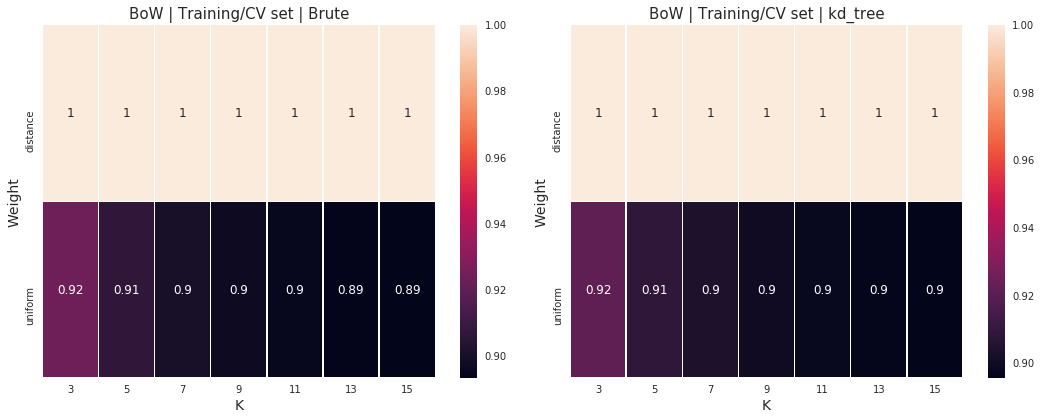

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_bow_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
#plt.show()

plt.subplot(1,2,2)
sbn.heatmap(data=DF_bow_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)

plt.tight_layout()
plt.show()

Transform Test data in BoW format

In [0]:
X_test_transformed = bow_fit.transform(X_test)

In [0]:
clf.score(X_test_transformed, y_test)

0.8891

### Tfidf

In [0]:
tfidf = TfidfVectorizer(ngram_range=(1,1))

In [0]:
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Fit the train reviews corpus into Tfidf format

In [0]:
tfidf_fit = tfidf.fit(X_train)

In [0]:
tfidf_fit

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

Transform Train reviews

In [0]:
try:
    del(X_train_transformed)
except:
    print('variable not found.')
    
X_train_transformed = tfidf_fit.transform(X_train)

variable not found.


In [0]:
X_train_transformed

<40000x24600 sparse matrix of type '<class 'numpy.float64'>'
	with 1190663 stored elements in Compressed Sparse Row format>

SVD on Tfidf reviews for kd_tree

In [0]:
try:
    del(X_train_transformed_svd)
except:
    print('variable not found.')

In [0]:
svd = TruncatedSVD(n_components=100, random_state = 7)
X_train_transformed_svd = svd.fit_transform(X_train_transformed)
X_train_transformed_svd.shape

(40000, 100)

In [0]:
try:
    del(my_cv)
    del(tscv)
except:
    print('Some variables not found.')

tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(X_train_transformed_svd)

In [0]:
knn = KNeighborsClassifier(algorithm = 'kd_tree')

param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance']
             }

clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, return_train_score=True, n_jobs=-1)

In [0]:
clf.fit(X_train_transformed_svd, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f9024261f10>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
DF_tfidf_kd_train = k_weight_score(clf.cv_results_)

In [0]:
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_tfidf_kd_train_50k.pkl','wb')
pickle.dump(DF_tfidf_kd_train,fname)
fname.close()



---



Tfidf Brute

In [0]:
try:
    del(my_cv)
    del(tscv)
except:
    print('Some variables not found.')

tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(X_train_transformed)

In [0]:
del(clf)

knn = KNeighborsClassifier(algorithm='brute')
param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance']
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, return_train_score=True)

In [0]:
clf.fit(X_train_transformed, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f902a3f9830>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
DF_tfidf_brute_train = k_weight_score(clf.cv_results_)

In [0]:
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_tfidf_brute_train.pkl','wb')
pickle.dump(DF_tfidf_brute_train,fname)
fname.close()

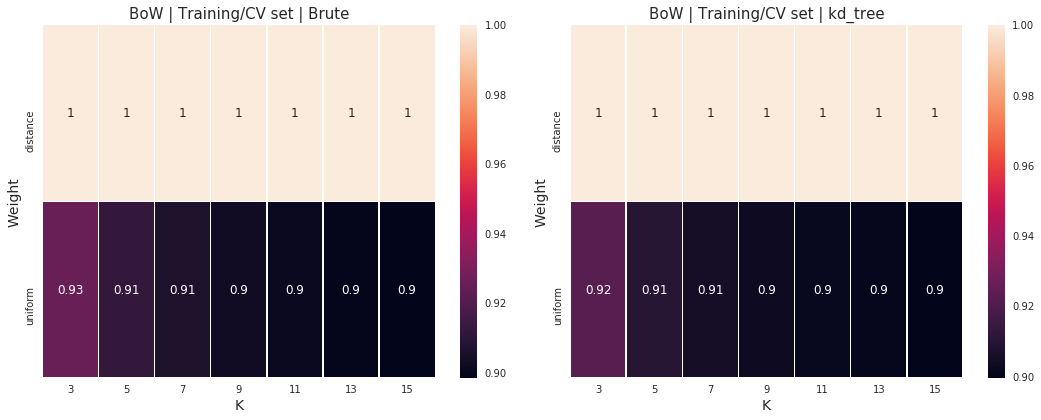

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_tfidf_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
#plt.show()

plt.subplot(1,2,2)
sbn.heatmap(data=DF_tfidf_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)

plt.tight_layout()
plt.show()

**Transform test data**

In [0]:
X_test_transformed = tfidf_fit.transform(X_test)

In [0]:
X_test_transformed

<10000x24600 sparse matrix of type '<class 'numpy.float64'>'
	with 291255 stored elements in Compressed Sparse Row format>

In [0]:
clf.score(X_test_transformed, y_test)

0.8946

W2V

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [0]:
#!pip install --upgrade pip
#!pip install gensim
#!pip install google-compute-engine

In [0]:
# Training a Word2Vec model using our own corpus

list_of_reviews = []

for review in X_train:
    list_of_reviews.append(review.decode('utf-8').split())

In [0]:
len(list_of_reviews)

40000

In [0]:
w2v_model = Word2Vec(list_of_reviews, min_count=4,size=50,workers=4)

In [0]:
words = list(w2v_model.wv.vocab)
print(len(words))

9594


In [0]:
Calculate Avg. W2V representation of the training corpus.

In [0]:
corpus_vec_train = np.zeros(shape=(50))

for review in X_train:
    review_vector = np.zeros(shape=(50))
    for word in review.decode('utf-8').split():
        try:
            
            review_vector += w2v_model.wv[word]
            
        except KeyError:
            continue
    
    review_vector /= 50
    corpus_vec_train=np.vstack((corpus_vec_train,review_vector))    
corpus_vec_train=np.delete(corpus_vec_train, 0, axis=0)

In [0]:
corpus_vec_train.shape

(40000, 50)

In [0]:
try:
    del(tscv, my_cv)
except:
    print('variable/s not found.')
    
tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(corpus_vec_train)

In [0]:
try:
    del(clf)
except:
    print('variable not found')

In [0]:
#del(clf)
knn = KNeighborsClassifier(algorithm='kd_tree')
param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance']
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, return_train_score=True, n_jobs=3)

In [0]:
clf.fit(corpus_vec_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f67f87dbf10>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=3,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
DF_w2v_kd_train = k_weight_score(clf.cv_results_)

In [0]:
import pickle
fname = open('/home/ucanreachtvk/data/knn_pickle_files/DF_w2v_kd_train_50k.pkl','wb')
pickle.dump(DF_w2v_kd_train,fname)
fname.close()

In [0]:
del(clf)
del(tscv, my_cv)

tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(corpus_vec_train)

In [0]:
#del(clf)
knn = KNeighborsClassifier(algorithm='brute')
param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance']
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=2, return_train_score=True)

In [0]:
clf.fit(corpus_vec_train, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f67f8801f10>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
DF_w2v_brute_train = k_weight_score(clf.cv_results_)

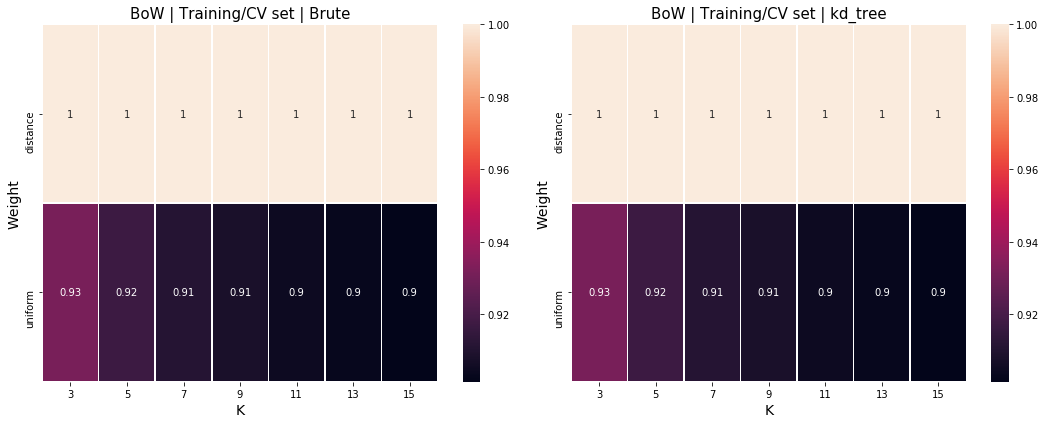

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_w2v_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
#plt.show()

plt.subplot(1,2,2)
sbn.heatmap(data=DF_w2v_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)

plt.tight_layout()
plt.show()

transform test

In [0]:
corpus_vec_test = np.zeros(shape=(50))

for review in X_test:
    review_vector = np.zeros(shape=(50))
    for word in review.decode('utf-8').split():
        try:
            
            review_vector += w2v_model.wv[word]
            
        except KeyError:
            continue
    
    review_vector /= 50
    corpus_vec_test=np.vstack((corpus_vec_test,review_vector))    
corpus_vec_test=np.delete(corpus_vec_test, 0, axis=0)

In [0]:
corpus_vec_test.shape

(10000, 50)

In [0]:
clf.score(corpus_vec_test, y_test)

0.8962

### Tfidf weighted W2V

In [0]:
features = tfidf_fit.get_feature_names()

In [0]:
corpus_train_tfidf_weighted_w2v = np.zeros(shape=(50))

review_number = 0

for review in X_train:
    review_vector_tfidf_weighted = np.zeros(shape=(50))
    tfidf_sum = 0
    for word in review.decode('utf-8').split():
        try:
            tfidf_value = X_train_transformed[review_number, features.index(word)]
            review_vector_tfidf_weighted += w2v_model.wv[word] * tfidf_value
            tfidf_sum += tfidf_value
            
        except KeyError:
            continue
    
    review_number += 1
    
    if tfidf_sum !=0:
        review_vector_tfidf_weighted /= tfidf_sum
    corpus_train_tfidf_weighted_w2v=np.vstack((corpus_train_tfidf_weighted_w2v,review_vector_tfidf_weighted))
    
corpus_train_tfidf_weighted_w2v = np.delete(corpus_train_tfidf_weighted_w2v, 0, axis=0)

In [0]:
corpus_train_tfidf_weighted_w2v.shape

(40000, 50)

In [0]:
try:
    del(tscv)
    del(my_cv)
except:
    pass

tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(corpus_train_tfidf_weighted_w2v)

In [0]:
my_cv

<generator object TimeSeriesSplit.split at 0x7f67f82fc468>

In [0]:
del(clf)

In [0]:
#del(clf)
knn = KNeighborsClassifier(algorithm = 'kd_tree')
param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance'],
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=-1, return_train_score=True)

In [0]:
clf.fit(corpus_train_tfidf_weighted_w2v, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f67f82fc468>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
DF_tfidf_weighted_w2v_kd_train = k_weight_score(clf.cv_results_)

In [0]:
try:
    
    del(clf, tscv, my_cv)
except:
    print('variables not found.')
    
tscv = TimeSeriesSplit(n_splits=5)
my_cv = tscv.split(corpus_train_tfidf_weighted_w2v)

knn = KNeighborsClassifier(algorithm = 'brute')

param_grid = {
                'n_neighbors':[3,5,7,9,11,13,15],
                'weights' : ['uniform', 'distance']
             }
clf = GridSearchCV(estimator=knn, cv=my_cv, param_grid=param_grid, n_jobs=2, return_train_score=True)

In [0]:
clf.fit(corpus_train_tfidf_weighted_w2v, y_train)

GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x7f67f82c3e08>,
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=2,
       param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [0]:
DF_tfidf_weighted_w2v_brute_train = k_weight_score(clf.cv_results_)

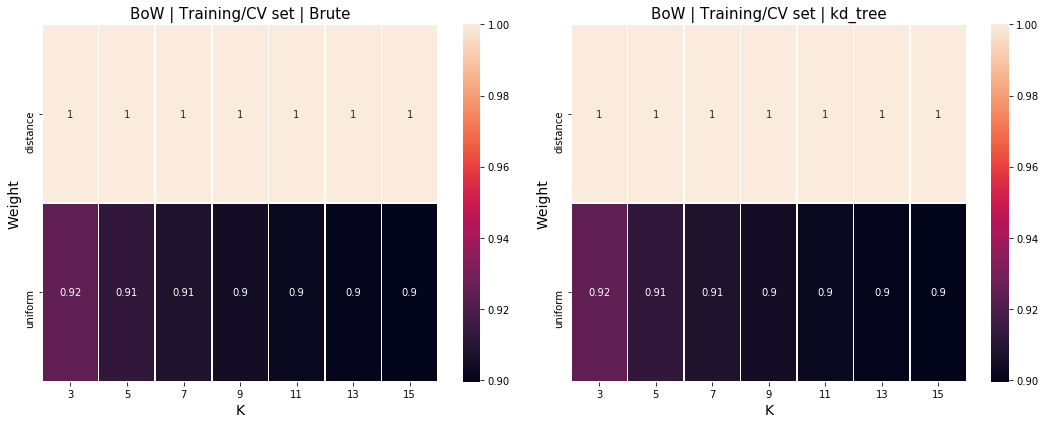

In [0]:
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sbn.heatmap(data=DF_tfidf_weighted_w2v_brute_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | Brute', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)
#plt.show()

plt.subplot(1,2,2)
sbn.heatmap(data=DF_tfidf_weighted_w2v_kd_train.pivot('weight','k','score'), annot=True, linewidth = 0.5)
plt.title('BoW | Training/CV set | kd_tree', fontsize = 15)
plt.xlabel('K', fontsize = 14)
plt.ylabel('Weight', fontsize = 14)

plt.tight_layout()
plt.show()

Transform test data

In [0]:
corpus_test_tfidf_weighted_w2v = np.zeros(shape=(50))

review_number = 0

for review in X_test:
    
    review_vector_tfidf_weighted = np.zeros(shape=(50))
    tfidf_sum = 0
    for word in review.decode('utf-8').split():
        
            flag_tfidf = True
            flag_w2v = True
            
            try:
                
                tfidf_value = X_train_transformed[review_number, features.index(word)]
                    
            except ValueError as v:
                
                flag_tfidf = False
                tfidf_value = 1
                    
            try:
                w2v_value = w2v_model.wv[word]
                review_vector_tfidf_weighted += w2v_value * tfidf_value    
                if flag_tfidf == True:
                    tfidf_sum += tfidf_value
                    
                

            except KeyError:
                
                flag_w2v = False
                continue     
                    
            
            #review_vector_tfidf_weighted += w2v_model.wv[word] * tfidf_value
            #tfidf_sum += tfidf_value
                        
            
    review_number += 1
    if tfidf_sum != 0:
        review_vector_tfidf_weighted /= tfidf_sum
    corpus_test_tfidf_weighted_w2v=np.vstack((corpus_test_tfidf_weighted_w2v,review_vector_tfidf_weighted))
    
corpus_test_tfidf_weighted_w2v = np.delete(corpus_test_tfidf_weighted_w2v, 0, axis=0)

In [0]:
corpus_test_tfidf_weighted_w2v[~np.isnan(corpus_test_tfidf_weighted_w2v).any(axis=1)].shape

(10000, 50)

In [0]:
corpus_test_tfidf_weighted_w2v.shape

(10000, 50)

In [0]:
clf.score(corpus_test_tfidf_weighted_w2v, y_test)

0.8766